In [1]:
from selenium import webdriver
import time 
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import re
import googlemaps
import urllib
from urllib.request import urlopen, Request
from tqdm import tqdm
import folium
import json
import statistics
# from glob import glob

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
driver = webdriver.Chrome("../driver/chromedriver")
starbucksUrl = "https://www.starbucks.co.kr/store/store_map.do"

# Move to Starbucks Page
driver.get(starbucksUrl)
time.sleep(3)

In [4]:
# 지역 검색 Click
driver.find_element_by_xpath('//*[@id="container"]/div/form/fieldset/div/section/article[1]/article/header[2]/h3/a').click()
time.sleep(1)
# 서울 Click
driver.find_element_by_xpath('//*[@id="container"]/div/form/fieldset/div/section/article[1]/article/article[2]/div[1]/div[2]/ul/li[1]/a').click()
time.sleep(1)
# 전체 Click
driver.find_element_by_xpath('//*[@id="mCSB_2_container"]/ul/li[1]/a').click()
time.sleep(4)

In [5]:
# Get html from : Selenium to BeatufulSoup
li_list = driver.find_element_by_xpath('//*[@id="mCSB_3_container"]/ul').get_attribute('innerHTML')
soup = BeautifulSoup(li_list, 'html.parser')
li_list = soup.find_all('li', class_='quickResultLstCon')

# Make Empty DF
col = ["Brand", "Name", "Addr", "Gu", "lat", "lng"]
df_SB = pd.DataFrame({"Brand":range(0,len(li_list))})
for c in col:
    df_SB[col] = np.nan

In [6]:
# Fill up DF
for i in range(0,len(li_list)):
    df_SB.iloc[i, 0] = "스타벅스"
    df_SB.iloc[i, 1] = li_list[i]['data-name'].strip()
    df_SB.iloc[i, 2] = li_list[0].find('p', class_='result_details').contents[0].strip()
    df_SB.iloc[i, 3] = li_list[i].find('p', class_='result_details').text.split()[1]
    df_SB.iloc[i, 4] = li_list[i]['data-lat']
    df_SB.iloc[i, 5] = li_list[i]['data-long']

In [7]:
# Find Na Value
df_SB.isna().sum()

Brand    0
Name     0
Addr     0
Gu       0
lat      0
lng      0
dtype: int64

In [8]:
df_SB["Gu"].unique()

array(['강남구', '강북구', '강서구', '관악구', '광진구', '금천구', '노원구', '도봉구', '동작구',
       '마포구', '서대문구', '서초구', '성북구', '송파구', '양천구', '영등포구', '은평구', '종로구',
       '중구', '강동구', '구로구', '동대문구', '성동구', '용산구', '중랑구'], dtype=object)

In [9]:
# 구 숫자
seoul_gu_list = ["강남구","강동구","강북구","강서구","관악구","광진구","구로구","금천구","노원구","도봉구","동대문구","동작구","마포구","서대문구","서초구","성동구","성북구","송파구","양천구","영등포구","용산구","은평구","종로구","중구","중랑구"]
print(len(seoul_gu_list))
print(df_SB["Gu"].nunique())

25
25


In [10]:
df_SB.head()

,Brand,Name,Addr,Gu,lat,lng
0,스타벅스,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동),강남구,37.501087,127.043069
1,스타벅스,논현역사거리,서울특별시 강남구 언주로 425 (역삼동),강남구,37.510178,127.022223
2,스타벅스,신사역성일빌딩,서울특별시 강남구 언주로 425 (역삼동),강남구,37.514132,127.020563
3,스타벅스,국기원사거리,서울특별시 강남구 언주로 425 (역삼동),강남구,37.499517,127.031495
4,스타벅스,스탈릿대치R,서울특별시 강남구 언주로 425 (역삼동),강남구,37.494668,127.062583


In [14]:
ediyaUrl = 'https://www.ediya.com/contents/find_store.html'

# Move to Ediya Page
driver.get(ediyaUrl)
time.sleep(3)

In [15]:
# 주소 Click
driver.find_element_by_xpath('//*[@id="contentWrap"]/div[3]/div/div[1]/ul/li[2]/a').click()
time.sleep(1)

In [16]:
col = ["Brand", "Name", "Addr", "Gu", "lat", "lng"]
df_ED = pd.DataFrame(columns = col)

gcnt = 0
gmaps_key = ""
gmaps = googlemaps.Client(key=gmaps_key)

for gu in seoul_gu_list:
    # 구 입력
    ele = driver.find_element_by_xpath('//*[@id="keyword"]')
    ele.clear()
    ele.send_keys("서울 " + gu)
    driver.find_element_by_xpath('//*[@id="keyword_div"]/form/button').click()
    time.sleep(1)
    
    # Get html from : Selenium to BeatufulSoup
    li_list = driver.find_element_by_xpath('//*[@id="placesList"]').get_attribute('innerHTML')
    soup = BeautifulSoup(li_list, 'html.parser')
    li_list = soup.find_all('li', class_='item')
    
    # Make Empty DF
    df_ED_tmp = pd.DataFrame({"Brand":range(0,len(li_list))})
    for c in col:
        df_ED_tmp[col] = np.nan
        
    # Fill up DF
    for i in range(0,len(li_list)):
        df_ED_tmp.iloc[i, 0] = "이디야"
        df_ED_tmp.iloc[i, 1] = li_list[i].find('dt').text.strip()
        df_ED_tmp.iloc[i, 2] = li_list[i].find('dd').text.strip()
        df_ED_tmp.iloc[i, 3] = li_list[i].find('dd').text.split()[1]

    df_ED = df_ED.append(df_ED_tmp)

In [17]:
df_ED.reset_index(inplace=True)
df_ED.drop("index", axis=1, inplace=True)

In [18]:
# 주소를 geocode로 lat, lng search
for idx, rows in df_ED.iterrows():
    # Geocode
    tmp = gmaps.geocode(rows['Addr'], language="ko")
    # Geocode에 출력이 안될 경우
    if tmp != []:
        df_ED.loc[idx, "lat"] = float(tmp[0].get("geometry")["location"]["lat"])
        df_ED.loc[idx, "lng"] = float(tmp[0].get("geometry")["location"]["lng"])
    tmp = []
    time.sleep(0.1)

In [19]:
df_ED.isna().sum()

Brand    0
Name     0
Addr     0
Gu       0
lat      0
lng      0
dtype: int64

In [20]:
df_ED.head()

,Brand,Name,Addr,Gu,lat,lng
0,이디야,강남YMCA점,서울 강남구 논현동,강남구,37.51353,127.031534
1,이디야,강남구청역아이티웨딩점,"서울 강남구 학동로 338 (논현동, 강남파라곤)",강남구,37.516579,127.040342
2,이디야,강남논현학동점,서울 강남구 논현로131길 28 (논현동),강남구,37.514227,127.028666
3,이디야,강남대치점,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",강남구,37.504296,127.063053
4,이디야,강남도산점,서울 강남구 도산대로37길 20 (신사동),강남구,37.522241,127.031481


In [21]:
driver.close()
driver.quit()

In [22]:
df = df_ED.append(df_SB)
df.to_excel("./Coffee.xlsx",index=False)

In [23]:
df_new = pd.read_excel("./Coffee.xlsx", index_col=None)

In [24]:
df_SB = df_new[df_new['Brand']=='스타벅스']
df_ED= df_new[df_new['Brand']=='이디야']

# Folium으로 매장 시각화

In [26]:
# folium 
m = folium.Map(location=[df_new["lat"].mean(), df_new["lng"].mean()], zoom_start=11)

for idx, rows in df_SB.iterrows():
    # location 
    lat, lng = rows['lat'], rows['lng']
    # Marker 
    folium.Marker(
        location=[lat, lng],
        popup=rows["Brand"] + rows["Addr"],
        tooltip=rows['Name'], 
        icon=folium.Icon(
            icon="coffee",
            color="green",
            icon_color="white",
            prefix="fa",
        )
    ).add_to(m)
    
for idx, rows in df_ED.iterrows():
    # location 
    lat, lng = rows['lat'], rows['lng']
    # Marker 
    folium.Marker(
        location=[lat, lng],
        popup=rows["Brand"] + rows["Addr"],
        tooltip=rows['Name'], 
        icon=folium.Icon(
            icon="coffee",
            color="blue",
            icon_color="white",
            prefix="fa",
        )
    ).add_to(m)
m         

- 매장이 너무 많아 하나씩 보기는 힘들다...

In [27]:
print("StarBucks 매장 수: {}".format(len(df_SB)))
print("Ediya 매장 수: {}".format(len(df_ED)))

StarBucks 매장 수: 566
Ediya 매장 수: 722


In [28]:
geo_path = "../data/02. skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

In [29]:
df_new_cnt = df_new
df_new_cnt["cnt"] = 1

In [30]:
df_new_cnt_agg = df_new_cnt.groupby(["Gu", "Brand"])["cnt"].sum().reset_index()
df_new_cnt_agg_pvt = df_new_cnt_agg.pivot_table(index="Gu", columns="Brand", values='cnt', aggfunc='sum').reset_index()
df_new_cnt_agg_pvt.columns = ["Gu", "SB", 'ED']
df_new_cnt_agg_pvt['pro'] =  df_new_cnt_agg_pvt['ED'] / df_new_cnt_agg_pvt['SB']

In [31]:
df_new_cnt_agg_pvt.set_index("Gu", inplace=True)
df_new_cnt_agg_pvt.head(3)

,SB,ED,pro
Gu,,,
강남구,87,45,0.517241
강동구,16,25,1.562500
강북구,6,20,3.333333


# 구별 매장 수와 스타벅스 대비 이디야 매장 수의 비율을 확인해 보자

In [32]:
my_map = folium.Map(location=[df_new["lat"].mean(), df_new["lng"].mean()], zoom_start=11)

my_map.choropleth(
    geo_data=geo_str,
    data=df_new_cnt_agg_pvt["pro"],
    columns=[df_new_cnt_agg_pvt.index, df_new_cnt_agg_pvt["pro"]],
    fill_color='BuPu',
    key_on="feature.id",
    fill_opacity=0.7,
    #line_opacity=0.2,
)
#folium.Marker([37.546532751824586, 127.14078218193266]).add_to(my_map)
for g in geo_str['features']:
    gu = g['id']
    coord = g['geometry']['coordinates'][0]
    lat, lng = statistics.mean([i[1] for i in coord]), statistics.mean([i[0] for i in coord])
    SB_cnt = int(df_new_cnt_agg.loc[(df_new_cnt_agg['Brand']=='스타벅스') & (df_new_cnt_agg['Gu']==gu), "cnt"])
    ED_cnt = int(df_new_cnt_agg.loc[(df_new_cnt_agg['Brand']=='이디야') & (df_new_cnt_agg['Gu']==gu), "cnt"])
    
    folium.CircleMarker(
        [lat, lng-0.01],
        radius=SB_cnt * 0.5,
        tooltip= '스타벅스 '+ gu +' 매장수 : ' + str(SB_cnt),
        color="#316e4d",
        fill=True,
        fill_color="#316e4d",
    ).add_to(my_map)

    folium.CircleMarker(
        [lat, lng+0.01],
        radius=ED_cnt * 0.5,
        tooltip='이디야 '+ gu +' 매장수 : ' + str(ED_cnt),
        color="#132e62",
        fill=True,
        fill_color="#132e62",
    ).add_to(my_map)
my_map

## 스타벅스는 특정 구에 매장이 몰려있고, 이디야는 전체적으로 고르게 분포하는 듯 보인다

In [33]:
# 한글 깨지지 않게
import matplotlib.pyplot as plt 
import seaborn as sns 
import platform
from matplotlib import font_manager, rc 

plt.rcParams["axes.unicode_minus"] = False 
# %matplotlib inline 
get_ipython().run_line_magic("matplotlib", "inline")

if platform.system() == "Darwin":
    rc("font", family="Arial Unicode MS")
elif platform.system() == "Windows":
    rc("font", family="Malgun Gothic")
else:
    print("Unkown system. sorry~~")

## harversine 모듈을 이용하여 가장 근처의 스타벅스 매장과의 거리를 구해보자

In [34]:
from haversine import haversine
import sys

df_ED_Dist = df_ED
df_ED_Dist['minDist'] = np.nan
for idx, rows in tqdm(df_ED_Dist.iterrows()):
    minValue = sys.maxsize
    for idx2, rows2 in df_SB.iterrows():
        tmp = haversine(rows[['lng','lat']], rows2[['lng','lat']])
        if minValue > tmp:
            minValue = tmp
    df_ED_Dist.loc[idx, "minDist"] = minValue

722it [08:21,  1.44it/s]


## 구별 스타벅스와 200m 이내의 이디야 매장 수를 그래프로 표현해보자

In [35]:
df_R1 = df_ED_Dist
df_R1 = df_R1.loc[df_R1['minDist']<=0.2]
len(df_R1)

279

In [36]:
df_R1['cnt'] = 1
df_R1_Pivot = df_R1[["Gu","cnt"]].pivot_table(index=["Gu"],values=["cnt"], aggfunc='sum')

In [37]:
print("스타벅스 매장 200m 부근에 있는 이디야 매장 전체 {:.1f}%".format(df_R1.loc[df_R1['minDist']<=0.5]['cnt'].sum() / len(df_ED) * 100))

스타벅스 매장 200m 부근에 있는 이디야 매장 전체 38.6%


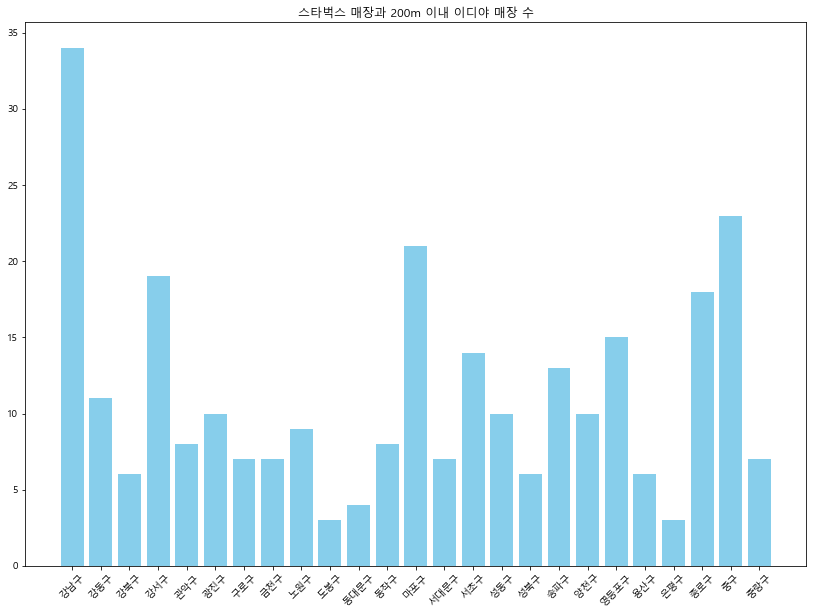

In [38]:
def drawGraph():
    plt.figure(figsize=(14, 10))
    plt.bar(df_R1_Pivot.index, df_R1_Pivot["cnt"], color='skyblue')
    plt.xticks(rotation = 45)
    plt.title("스타벅스 매장과 200m 이내 이디야 매장 수")
    plt.grid(False)
    plt.show() 
drawGraph()

## 이디야 매장 중 스타벅스 근처에 있는 매장이 가장 많은 Top 5를 확인해 보자

In [58]:
df_R1_Pivot.sort_values(by='cnt', ascending=False).head(5)

,cnt
Gu,
강남구,34
중구,23
마포구,21
강서구,19
종로구,17


## 5개 구의 매장 수 중 강서구를 제외한 나머지 구는 스타벅스 매장 비율이 많은 구이다

In [39]:
df_Gap = df_new
df_Gap['cnt'] = 1
df_Gap_Pvt = df_Gap[["Brand","Gu","cnt"]].pivot_table(index=["Brand","Gu"],values=["cnt"], aggfunc='sum')
df_Gap_Pvt.reset_index(inplace=True)
df_Gap_Pvt_ED = df_Gap_Pvt.loc[df_Gap_Pvt["Brand"]=="이디야"]

df_Gap_Pvt_ED['Gap'] = np.nan
for idx, rows in df_Gap_Pvt_ED.iterrows():
    df_Gap_Pvt_ED.loc[idx, "Gap"] = int(rows["cnt"]) - int(df_Gap_Pvt.loc[(df_Gap_Pvt["Brand"]=="스타벅스") & (df_Gap_Pvt["Gu"]==rows['Gu']),"cnt"])

In [40]:
df_Mg = df_ED_Dist
df_Mg["cnt"] = 1
df_Mg_Pvt = df_Mg[["Gu","cnt"]].pivot_table(index=["Gu"],values=["cnt"], aggfunc='sum')

df_Mg_Pvt['matchCnt'] = np.nan
df_Mg_Pvt['Gap'] = np.nan
df_Mg_Pvt.reset_index(inplace=True)
for idx, rows in df_Mg_Pvt.iterrows():
    df_Mg_Pvt.loc[idx, "matchCnt"] = df_R1_Pivot.loc[df_R1_Pivot.index==rows["Gu"], "cnt"].values[0]
    df_Mg_Pvt.loc[idx, "Gap"] = df_Gap_Pvt_ED.loc[df_Gap_Pvt_ED["Gu"]==rows["Gu"], "Gap"].values[0]
    
df_Mg_Pvt["match%"] = round(df_Mg_Pvt['matchCnt'] / df_Mg_Pvt['cnt'] * 100, 1)

In [41]:
df_Mg_Pvt['Gap_abs'] = abs(df_Mg_Pvt["Gap"])

## 스타벅스 근처 이디야 매장이 많은 순으로 데이터를 확인해 보자

In [42]:
df_Mg_Pvt.sort_values("match%", ascending=False).head(5)

,Gu,cnt,matchCnt,Gap,match%,Gap_abs
23,중구,29,23.0,-27.0,79.3,27.0
0,강남구,45,34.0,-42.0,75.6,42.0
22,종로구,31,18.0,-9.0,58.1,9.0
12,마포구,39,21.0,7.0,53.8,7.0
14,서초구,30,14.0,-18.0,46.7,18.0


## 이디야 매장이 많은 순으로 데이터를 확인해 보자

In [44]:
df_Mg_Pvt.sort_values("Gap", ascending=False).head(5)

,Gu,cnt,matchCnt,Gap,match%,Gap_abs
3,강서구,47,19.0,26.0,40.4,26.0
9,도봉구,23,3.0,20.0,13.0,20.0
24,중랑구,26,7.0,18.0,26.9,18.0
4,관악구,29,8.0,18.0,27.6,18.0
21,은평구,26,3.0,18.0,11.5,18.0


## 이번엔 차이가 많은 구, 적은 구 순으로 데이터를 확인해 보자

In [45]:
df_Mg_Pvt.sort_values("Gap_abs", ascending=False).head(5)

,Gu,cnt,matchCnt,Gap,match%,Gap_abs
0,강남구,45,34.0,-42.0,75.6,42.0
23,중구,29,23.0,-27.0,79.3,27.0
3,강서구,47,19.0,26.0,40.4,26.0
9,도봉구,23,3.0,20.0,13.0,20.0
8,노원구,31,9.0,18.0,29.0,18.0


In [47]:
df_Mg_Pvt.sort_values("Gap_abs", ascending=True).head(5)

,Gu,cnt,matchCnt,Gap,match%,Gap_abs
13,서대문구,21,7.0,1.0,33.3,1.0
19,영등포구,41,15.0,2.0,36.6,2.0
20,용산구,15,6.0,-6.0,40.0,6.0
17,송파구,40,13.0,6.0,32.5,6.0
12,마포구,39,21.0,7.0,53.8,7.0


# 결론
## 스타벅스 매장이 더 많은 일부 구에서 이디야 매장 근방일 %가 높다
## 하지만 이디야 매장이 더 많은 구에서는 근접률이 높지는않다
## 결론적으로 이디야가 스타벅스 매장 근처에 입점한다는 주장은 타당하지 않아 보인다
- 스타벅스 매장이 생긴 후에 인접한 이디야 매장이 생겼는지를 확인해 보면 더 명확한 결과가 나올 것 같다.
- 매장 설립일 데이터는 찾기가 어렵다...